In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.utils import shuffle
from PIL import Image
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import matplotlib.image as mpimg
import cv2
import tensorflow as tf

In [2]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True
config.gpu_options.visible_device_list='0'

sess = tf.compat.v1.Session(config=config)
tf.debugging.set_log_device_placement(True)
strategy = tf.distribute.MirroredStrategy()

print('Number of devices: {}\n'.format(strategy.num_replicas_in_sync))

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13002271157908358
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7070765568
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5268061490327318820
physical_device_desc: "device: 0, name: GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


In [3]:
file_list = os.listdir("data/IMG")

In [4]:
print(len(file_list))

36534


In [5]:
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']

df = pd.read_csv("data/driving_log.csv", names=columns)
#df = df.iloc[:,2:6]
df.head()

center  \
0  data/IMG/center_2017_04_06_17_06_56_921.jpg   
1  data/IMG/center_2017_04_06_17_06_57_009.jpg   
2  data/IMG/center_2017_04_06_17_06_57_085.jpg   
3  data/IMG/center_2017_04_06_17_06_57_170.jpg   
4  data/IMG/center_2017_04_06_17_06_57_249.jpg   

                                        left  \
0  data/IMG/left_2017_04_06_17_06_56_921.jpg   
1  data/IMG/left_2017_04_06_17_06_57_009.jpg   
2  data/IMG/left_2017_04_06_17_06_57_085.jpg   
3  data/IMG/left_2017_04_06_17_06_57_170.jpg   
4  data/IMG/left_2017_04_06_17_06_57_249.jpg   

                                        right  steering  throttle  reverse  \
0  data/IMG/right_2017_04_06_17_06_56_921.jpg       0.0       0.0      0.0   
1  data/IMG/right_2017_04_06_17_06_57_009.jpg       0.0       0.0      0.0   
2  data/IMG/right_2017_04_06_17_06_57_085.jpg       0.0       0.0      0.0   
3  data/IMG/right_2017_04_06_17_06_57_170.jpg       0.0       0.0      0.0   
4  data/IMG/right_2017_04_06_17_06_57_249.jpg       0.0       0.0      0.0   

          speed  
0  1.980000e-06  
1  7.090000e-06  
2  1.580000e-06  
3  2.670000e-07  
4  9.790000e-07

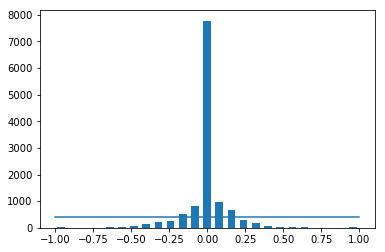

In [6]:
num_bins = 25
samples_per_bin = 400
hist, bins = np.histogram(df.iloc[:,3], num_bins)
center = (bins[:-1]+ bins[1:]) * 0.5
plt.bar(center, hist, width=0.05) #Plot the bar graph consisting of center and hist values
plt.plot((np.min(df.iloc[:,3]), np.max(df.iloc[:,3])), (samples_per_bin, samples_per_bin))

total data: 12178
removed: 8712
remaining: 3466


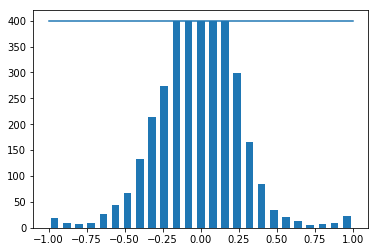

In [7]:
print('total data:', len(df))
# ctrl + / to comment a code
# for k in range(num_bins):
#  print('Set no: ', k)
#   print(data['steering'][k])
#   print(bins[k])
remove_list = []
for j in range(num_bins):
    list_ = []
    for i in range(len(df['steering'])):
        if df['steering'][i] >= bins[j] and df['steering'][i] <= bins[j+1]: #the steering angle in the range 0.96,0.97,0.95 would all belong to the same bin
            list_.append(i)
    list_ = shuffle(list_) #The above list is gonna contain all steering angles for a specific bin which are ordered in the manner the car was driven on the track. If we want to remove some set of data we need
    #make sure that the steering angles for the entire track is covered for which we use shuffle  
    list_ = list_[samples_per_bin:] #Isolate the list that goes beyond the threshold
    remove_list.extend(list_) #dispose the list by using extend which will allow to extend the list to what we wanna dispose right on to remove list

    
print('removed:', len(remove_list))
df.drop(df.index[remove_list], inplace=True) #specific rows of data which correspond to the removed data list will be dropped by going to their data.index
print('remaining:', len(df))
 
hist, _ = np.histogram(df['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(df['steering']), np.max(df['steering'])), (samples_per_bin, samples_per_bin))

In [8]:
def load_image_steering_data(df):
    images = []
    steering = []
    for i in range(len(df)):
        steer_index = df.iloc[i]
        left, middle, right = steer_index[0], steer_index[1], steer_index[2]
        images.append(left)
        steering.append(steer_index[3]-0.15)
        images.append(middle)
        steering.append(steer_index[3])
        images.append(right)
        steering.append(steer_index[3]+0.15)
        image_paths = np.asarray(images)
        steerings = np.asarray(steering)
    return image_paths, steerings
        
image_paths, steerings = load_image_steering_data(df)


In [9]:
print(image_paths[100])
print(steerings[100])

data/IMG/left_2017_04_06_17_07_04_001.jpg
-0.185771


In [10]:
train_x, test_x, train_y, test_y = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)

In [11]:
train_y.shape

(8318,)

Text(0.5, 1.0, 'Validation set')

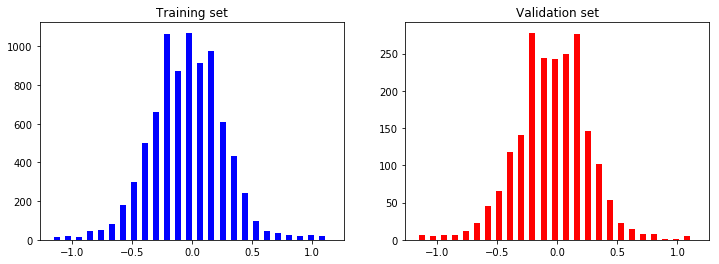

In [12]:
fig, axes = plt.subplots(1,2, figsize=(12, 4))
axes[0].hist(train_y, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(test_y, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

In [13]:
#augmentation technique 1--zoom
def zoom(image):
    zoom = iaa.Affine(scale=(1,1.3))
    zoomed = zoom.augment_image(image)
    return zoomed

data/IMG/left_2017_04_06_17_07_12_530.jpg


Text(0.5, 1.0, 'zoomed image')

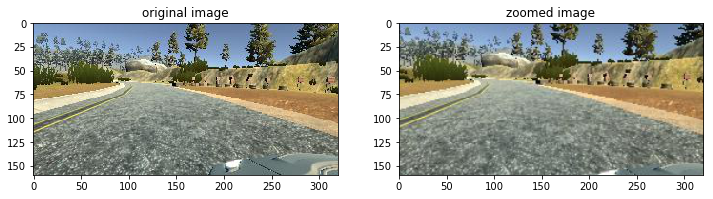

In [14]:
fig, axes = plt.subplots(1,2, figsize=(12,4))
selected_image = image_paths[random.randint(0,1000)]
print(selected_image)

image = mpimg.imread(selected_image)
axes[0].imshow(image)
axes[0].set_title("original image")

zoomed = zoom(image)
axes[1].imshow(zoomed)
axes[1].set_title("zoomed image")

In [15]:
#augmentation technique 2 -- pan
def pan(image):
    pan = iaa.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
    image = pan.augment_image(image)
    return image

Text(0.5, 1.0, 'panned image')

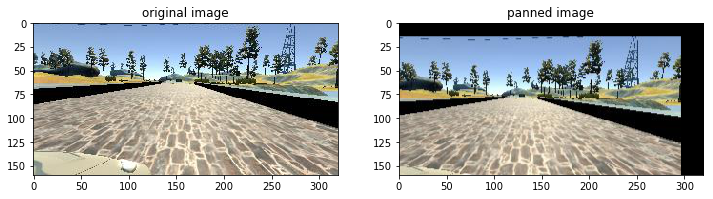

In [16]:
fig, axes = plt.subplots(1,2, figsize=(12,4))
selected_image = image_paths[random.randint(0,1000)]
image = mpimg.imread(selected_image)
axes[0].imshow(image)
axes[0].set_title("original image")

panned = pan(image)
axes[1].imshow(panned)
axes[1].set_title("panned image")

In [17]:
def insert_random_brightness(image):
    brightness = iaa.Multiply((0.2, 1.2))
    image = brightness.augment_image(image)
    return image

Text(0.5, 1.0, 'adjusted brightness image')

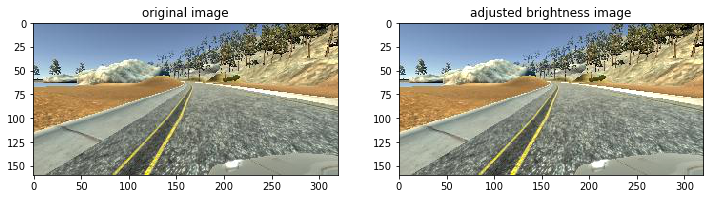

In [18]:
fig, axes = plt.subplots(1,2,figsize=(12,4))
selected_image = image_paths[random.randint(0,1000)]
image = mpimg.imread(selected_image)

axes[0].imshow(image)
axes[0].set_title("original image")

bright = insert_random_brightness(image)
axes[1].imshow(bright)
axes[1].set_title("adjusted brightness image")

In [19]:
def img_random_flip(image, steering):
    flipped = cv2.flip(image, 1)
    steering = -steering
    return flipped, steering

Text(0.5, 1.0, 'adjusted brightness image')

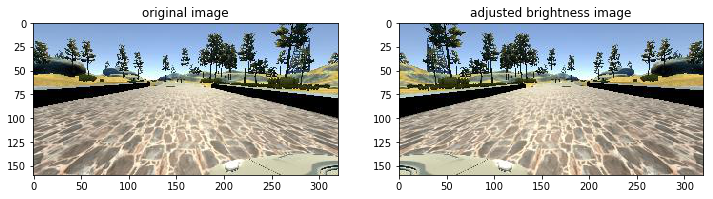

In [20]:
selected_index = random.randint(0,1000)
selected_image = image_paths[selected_index]
selected_steering = steerings[selected_index]

image = mpimg.imread(selected_image)
fig, axes = plt.subplots(1,2,figsize=(12,4))
axes[0].imshow(image)
axes[0].set_title("original image")

flipped_image, steering = img_random_flip(image, selected_steering)
axes[1].imshow(flipped_image)
axes[1].set_title("adjusted brightness image")

In [21]:
def random_augment(image, steering_angle): #randomize all the images in the dataset so as to not perform all augmentations on a single image itself 
    image = mpimg.imread(image)
    if np.random.rand() < 0.5: #on avg each augmentation will only be done on 50% of newly augmented images
        image = pan(image)
    if np.random.rand() < 0.5:
        image = zoom(image)
    if np.random.rand() < 0.5:
        image = insert_random_brightness(image)
    if np.random.rand() < 0.5:
        image, steering_angle = img_random_flip(image, steering_angle)
    
    return image, steering_angle

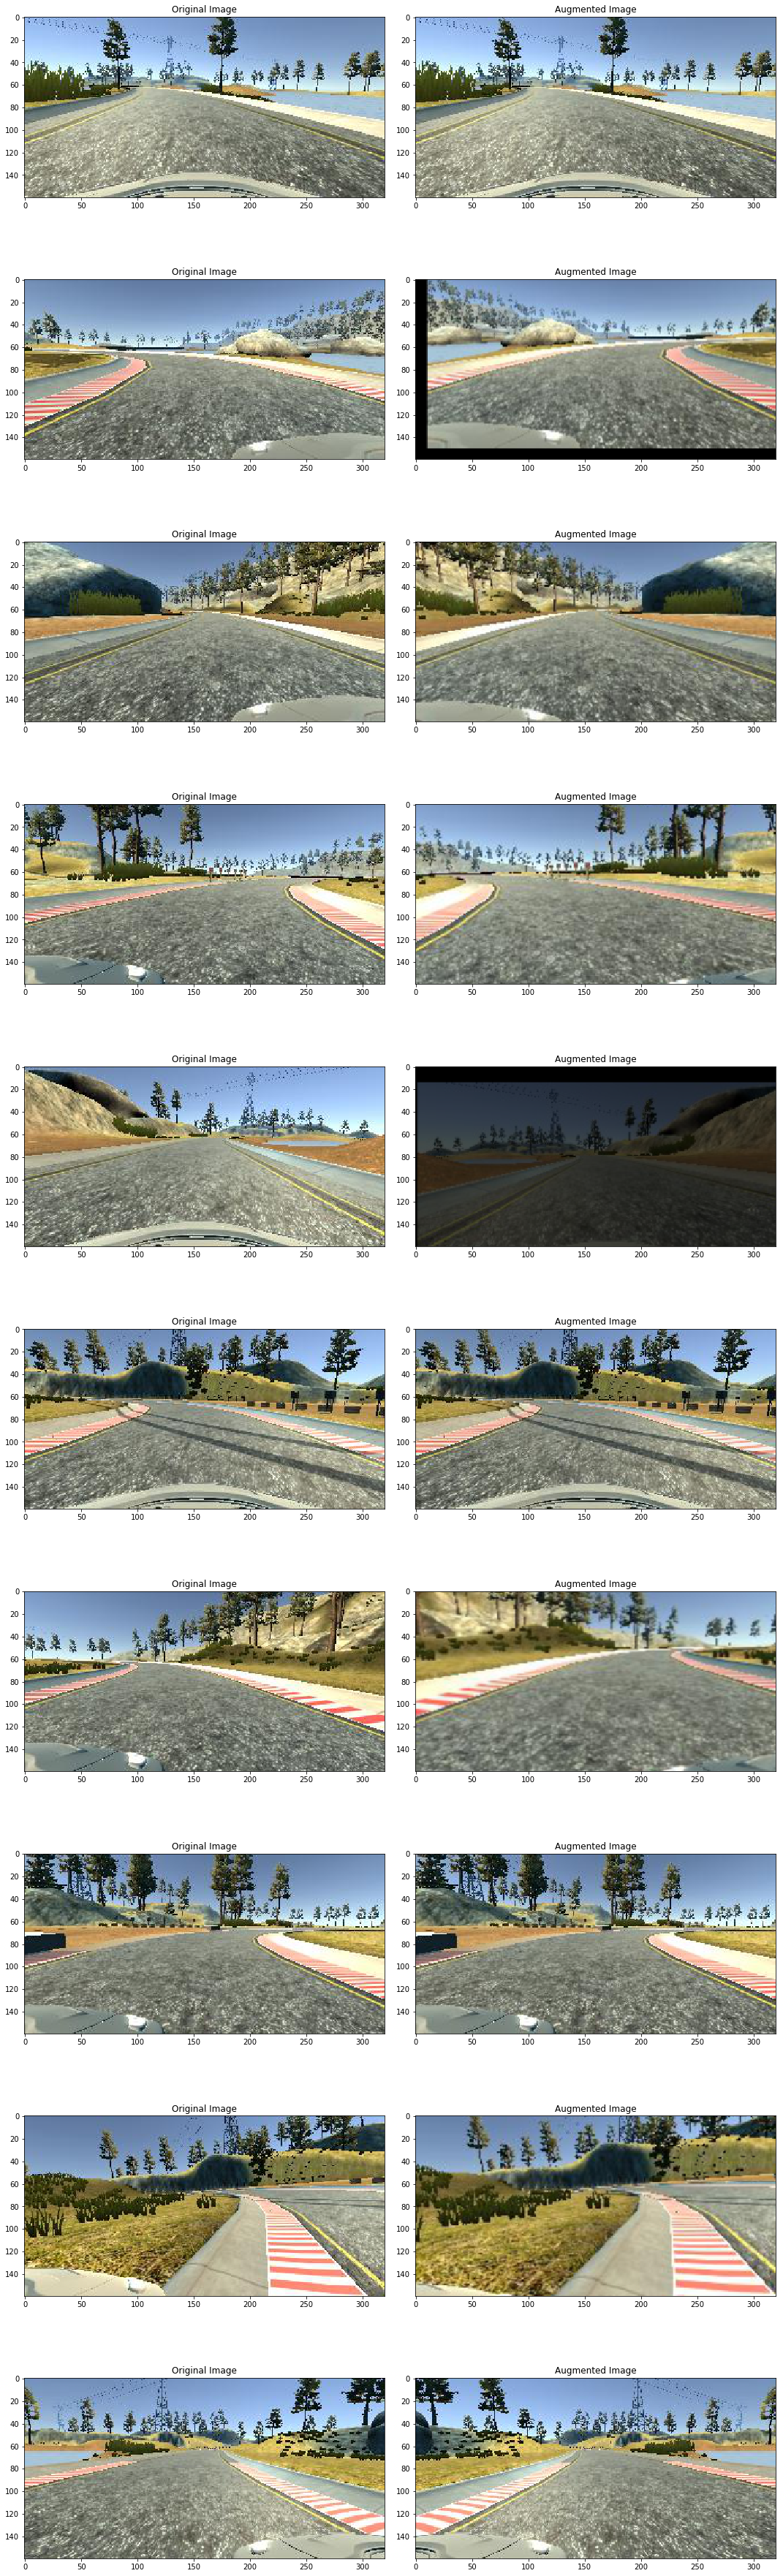

In [22]:
ncol = 2
nrow = 10
 
fig, axs = plt.subplots(nrow, ncol, figsize=(15, 50))
fig.tight_layout()
 
for i in range(10):
    randnum = random.randint(0, len(image_paths) - 1)
    random_image = image_paths[randnum]
    random_steering = steerings[randnum]
    
    original_image = mpimg.imread(random_image)
    augmented_image, steering = random_augment(random_image, random_steering)
    
    axs[i][0].imshow(original_image)
    axs[i][0].set_title("Original Image")
  
    axs[i][1].imshow(augmented_image)
    axs[i][1].set_title("Augmented Image")

(160, 320, 3)

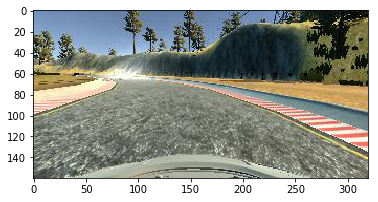

In [23]:
image = mpimg.imread(image_paths[0])
plt.imshow(image)
image.shape

In [24]:
def img_preprocess(image):
    image = image[60:135,:,:]
    image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    image = cv2.GaussianBlur(image,  (3, 3), 0)
    image = cv2.resize(image, (200, 66))
    image = image/255
    return image

Text(0.5, 1.0, 'cropped')

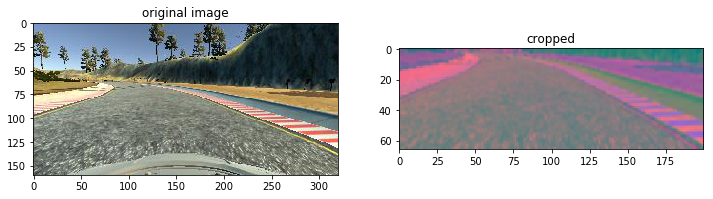

In [25]:
random_index = random.randint(0,len(image_paths))
image = mpimg.imread(image_paths[random_index])
cropped = img_preprocess(image)

fig, axes = plt.subplots(1,2, figsize=(12,4))
axes[0].imshow(image)
axes[0].set_title("original image")

axes[1].imshow(cropped)
axes[1].set_title("cropped")

In [26]:
#the generator allows to create augmeneted images on the fly rather than augmenting and storing each image and then running the model. THis is memory efficient too. 
#Since fit() requires the entire dataset as a numpy array in memory, which is why for larger datasets we make use of fit_generator() to generate augmented images on the fly
#when needed and this is done in batches
def batch_generator(image_paths, steering_ang, batch_size, istraining): #the last argument is a boolean and returns true when the data being fed is only a training.
  
  while True: #A loop that will run indefinitely 
    batch_img = []
    batch_steering = []
    
    for i in range(batch_size):
        random_index = random.randint(0, len(image_paths) - 1)
      
        if istraining:
            im, steering = random_augment(image_paths[random_index], steering_ang[random_index])
     
        else: #since validation data does not require any validation.
            im = mpimg.imread(image_paths[random_index])
            steering = steering_ang[random_index]
      
        im = img_preprocess(im)
        batch_img.append(im)
        batch_steering.append(steering)
    yield (np.asarray(batch_img), np.asarray(batch_steering))  #the yield return keyword comes under the class of functions called co-routine since it stores all the 
    #intialised variables within the func as opposed to sub-routine type funct. When the func is called again it does not reinitialise instead builds up on the previous data.

Text(0.5, 1.0, 'Validation Image')

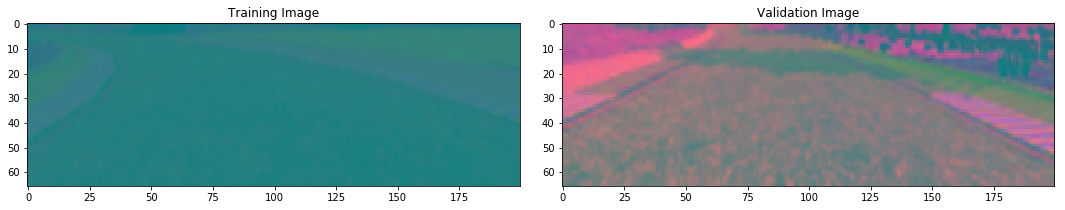

In [27]:

x_train_gen, y_train_gen = next(batch_generator(train_x, train_y, 1, 1)) #1 image fed and second 1 is to say that the boolean value is true
x_valid_gen, y_valid_gen = next(batch_generator(test_x, test_y, 1, 0))
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(x_train_gen[0])
axs[0].set_title('Training Image')
 
axs[1].imshow(x_valid_gen[0])
axs[1].set_title('Validation Image')

In [28]:
with strategy.scope():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(filters=24,kernel_size=(5,5),input_shape=(66,200,3),activation='elu',strides=(2, 2)),
        tf.keras.layers.Conv2D(filters=36,kernel_size=(5,5),activation='relu',strides=(2, 2)),
        tf.keras.layers.Conv2D(filters=48,kernel_size=(5,5),activation='relu',strides=(2, 2)),
        tf.keras.layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu'),
        tf.keras.layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(100, activation='elu'),
        tf.keras.layers.Dense(50, activation='elu'),
        tf.keras.layers.Dense(10, activation='elu'),
        tf.keras.layers.Dense(1)
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-4), loss='mse')

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/repl

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               1

In [30]:
history = model.fit_generator(batch_generator(train_x, train_y, 120, 1),         #since the i/p images will  be created real time so we call the batch_gen.
                                  steps_per_epoch=300, 
                                  epochs=15,
                                  validation_data=batch_generator(test_x, test_y, 120, 0),
                                  validation_steps=200,
                                  verbose=1,
                                  shuffle = 1)

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0


/home/ripon/anaconda3/envs/gpu2/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ComputeBatchSize in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op NotEqual in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DatasetCardinality in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing o

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhos

 76/300 [======>.......................] - ETA: 58s - loss: 0.0986Executing op __inference_train_function_1307 in device /job:localhost/replica:0/task:0/device:GPU:0


125/300 [===========>..................] - ETA: 46s - loss: 0.0966Executing op __inference_train_function_1307 in device /job:localhost/replica:0/task:0/device:GPU:0


174/300 [================>.............] - ETA: 33s - loss: 0.0949Executing op __inference_train_function_1307 in device /job:localhost/replica:0/task:0/device:GPU:0


223/300 [=====================>........] - ETA: 20s - loss: 0.0932Executing op __inference_train_function_1307 in device /job:localhost/replica:0/task:0/device:GPU:0


273/300 [==========================>...] - ETA: 7s - loss: 0.0917Executing op __inference_train_function_1307 in device /job:localhost/replica:0/task:0/device:GPU:0


300/300 [==============================] - ETA: 0s - loss: 0.0909Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ComputeBatchSize in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op NotEqual in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /

Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

 75/300 [======>.......................] - ETA: 58s - loss: 0.0690Executing op __inference_train_function_1307 in device /job:localhost/replica:0/task:0/device:GPU:0


124/300 [===========>..................] - ETA: 46s - loss: 0.0683Executing op __inference_train_function_1307 in device /job:localhost/replica:0/task:0/device:GPU:0


173/300 [================>.............] - ETA: 33s - loss: 0.0680Executing op __inference_train_function_1307 in device /job:localhost/replica:0/task:0/device:GPU:0


222/300 [=====================>........] - ETA: 20s - loss: 0.0679Executing op __inference_train_function_1307 in device /job:localhost/replica:0/task:0/device:GPU:0


272/300 [==========================>...] - ETA: 7s - loss: 0.0678Executing op __inference_train_function_1307 in device /job:localhost/replica:0/task:0/device:GPU:0


300/300 [==============================] - ETA: 0s - loss: 0.0677Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op MakeIterator in device /job:localhost

Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

 84/300 [=======>......................] - ETA: 54s - loss: 0.0664Executing op __inference_train_function_1307 in device /job:localhost/replica:0/task:0/device:GPU:0


133/300 [============>.................] - ETA: 42s - loss: 0.0656Executing op __inference_train_function_1307 in device /job:localhost/replica:0/task:0/device:GPU:0


182/300 [=================>............] - ETA: 30s - loss: 0.0649Executing op __inference_train_function_1307 in device /job:localhost/replica:0/task:0/device:GPU:0


231/300 [======================>.......] - ETA: 18s - loss: 0.0644Executing op __inference_train_function_1307 in device /job:localhost/replica:0/task:0/device:GPU:0


281/300 [===========================>..] - ETA: 5s - loss: 0.0640Executing op __inference_train_function_1307 in device /job:localhost/replica:0/task:0/device:GPU:0


300/300 [==============================] - ETA: 0s - loss: 0.0639Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op MakeIterator in device /job:localhost

Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op DeleteMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
300/300 [==============================] - 110s 369ms/step - loss: 0.0639 - val_loss: 0.0525
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Epoch 4/15
Executing op

 93/300 [========>.....................] - ETA: 55s - loss: 0.0623Executing op __inference_train_function_1307 in device /job:localhost/replica:0/task:0/device:GPU:0


142/300 [=============>................] - ETA: 42s - loss: 0.0621Executing op __inference_train_function_1307 in device /job:localhost/replica:0/task:0/device:GPU:0


191/300 [==================>...........] - ETA: 28s - loss: 0.0617Executing op __inference_train_function_1307 in device /job:localhost/replica:0/task:0/device:GPU:0


240/300 [=======================>......] - ETA: 15s - loss: 0.0613Executing op __inference_train_function_1307 in device /job:localhost/replica:0/task:0/device:GPU:0


290/300 [============================>.] - ETA: 2s - loss: 0.0612Executing op __inference_train_function_1307 in device /job:localhost/replica:0/task:0/device:GPU:0


300/300 [==============================] - ETA: 0s - loss: 0.0611Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op MakeIterator in device /job:localhost

Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

 52/300 [====>.........................] - ETA: 1:04 - loss: 0.0589Executing op __inference_train_function_1307 in device /job:localhost/replica:0/task:0/device:GPU:0


101/300 [=========>....................] - ETA: 52s - loss: 0.0590Executing op __inference_train_function_1307 in device /job:localhost/replica:0/task:0/device:GPU:0


150/300 [==============>...............] - ETA: 40s - loss: 0.0593Executing op __inference_train_function_1307 in device /job:localhost/replica:0/task:0/device:GPU:0


199/300 [==================>...........] - ETA: 27s - loss: 0.0594Executing op __inference_train_function_1307 in device /job:localhost/replica:0/task:0/device:GPU:0


248/300 [=======================>......] - ETA: 14s - loss: 0.0594Executing op __inference_train_function_1307 in device /job:localhost/replica:0/task:0/device:GPU:0


298/300 [============================>.] - ETA: 0s - loss: 0.0593Executing op __inference_train_function_1307 in device /job:localhost/replica:0/task:0/device:GPU:0


300/300 [==============================] - ETA: 0s - loss: 0.0593Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op MakeIterator in device /job:localhost

Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

 60/300 [=====>........................] - ETA: 59s - loss: 0.0544Executing op __inference_train_function_1307 in device /job:localhost/replica:0/task:0/device:GPU:0


109/300 [=========>....................] - ETA: 48s - loss: 0.0553Executing op __inference_train_function_1307 in device /job:localhost/replica:0/task:0/device:GPU:0


158/300 [==============>...............] - ETA: 36s - loss: 0.0558Executing op __inference_train_function_1307 in device /job:localhost/replica:0/task:0/device:GPU:0


207/300 [===================>..........] - ETA: 23s - loss: 0.0560Executing op __inference_train_function_1307 in device /job:localhost/replica:0/task:0/device:GPU:0


256/300 [========================>.....] - ETA: 11s - loss: 0.0561Executing op __inference_train_function_1307 in device /job:localhost/replica:0/task:0/device:GPU:0


300/300 [==============================] - ETA: 0s - loss: 0.0560Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op MakeIterator in device /job:localhost

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0

Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

 68/300 [=====>........................] - ETA: 1:00 - loss: 0.0587Executing op __inference_train_function_1307 in device /job:localhost/replica:0/task:0/device:GPU:0


117/300 [==========>...................] - ETA: 48s - loss: 0.0581Executing op __inference_train_function_1307 in device /job:localhost/replica:0/task:0/device:GPU:0


166/300 [===============>..............] - ETA: 35s - loss: 0.0576Executing op __inference_train_function_1307 in device /job:localhost/replica:0/task:0/device:GPU:0


215/300 [====================>.........] - ETA: 22s - loss: 0.0574Executing op __inference_train_function_1307 in device /job:localhost/replica:0/task:0/device:GPU:0


264/300 [=========================>....] - ETA: 9s - loss: 0.0574Executing op __inference_train_function_1307 in device /job:localhost/replica:0/task:0/device:GPU:0


300/300 [==============================] - ETA: 0s - loss: 0.0573Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op MakeIterator in device /job:localhost

Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

 76/300 [======>.......................] - ETA: 55s - loss: 0.0580Executing op __inference_train_function_1307 in device /job:localhost/replica:0/task:0/device:GPU:0


125/300 [===========>..................] - ETA: 44s - loss: 0.0578Executing op __inference_train_function_1307 in device /job:localhost/replica:0/task:0/device:GPU:0


174/300 [================>.............] - ETA: 32s - loss: 0.0577Executing op __inference_train_function_1307 in device /job:localhost/replica:0/task:0/device:GPU:0


223/300 [=====================>........] - ETA: 20s - loss: 0.0574Executing op __inference_train_function_1307 in device /job:localhost/replica:0/task:0/device:GPU:0


273/300 [==========================>...] - ETA: 7s - loss: 0.0571Executing op __inference_train_function_1307 in device /job:localhost/replica:0/task:0/device:GPU:0


300/300 [==============================] - ETA: 0s - loss: 0.0570Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op MakeIterator in device /job:localhost

Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

 85/300 [=======>......................] - ETA: 58s - loss: 0.0569Executing op __inference_train_function_1307 in device /job:localhost/replica:0/task:0/device:GPU:0


134/300 [============>.................] - ETA: 44s - loss: 0.0566Executing op __inference_train_function_1307 in device /job:localhost/replica:0/task:0/device:GPU:0


183/300 [=================>............] - ETA: 31s - loss: 0.0566Executing op __inference_train_function_1307 in device /job:localhost/replica:0/task:0/device:GPU:0


232/300 [======================>.......] - ETA: 18s - loss: 0.0564Executing op __inference_train_function_1307 in device /job:localhost/replica:0/task:0/device:GPU:0


282/300 [===========================>..] - ETA: 4s - loss: 0.0562Executing op __inference_train_function_1307 in device /job:localhost/replica:0/task:0/device:GPU:0


300/300 [==============================] - ETA: 0s - loss: 0.0562Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op MakeIterator in device /job:localhost

Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Epoch 10/15
Executing op __inference_train_function_1307 in device /job:localhost/replica:0/task:0/device:GPU:0
  1/300 [..............................] - ETA: 5s - loss: 0.0397Executing op __inference_train_function_1307 in device /job:localhost/replica:0/task:0/device:GPU:0
Execut

 94/300 [========>.....................] - ETA: 51s - loss: 0.0539Executing op __inference_train_function_1307 in device /job:localhost/replica:0/task:0/device:GPU:0


143/300 [=============>................] - ETA: 39s - loss: 0.0538Executing op __inference_train_function_1307 in device /job:localhost/replica:0/task:0/device:GPU:0


192/300 [==================>...........] - ETA: 27s - loss: 0.0537Executing op __inference_train_function_1307 in device /job:localhost/replica:0/task:0/device:GPU:0


241/300 [=======================>......] - ETA: 15s - loss: 0.0536Executing op __inference_train_function_1307 in device /job:localhost/replica:0/task:0/device:GPU:0


291/300 [============================>.] - ETA: 2s - loss: 0.0537Executing op __inference_train_function_1307 in device /job:localhost/replica:0/task:0/device:GPU:0


300/300 [==============================] - ETA: 0s - loss: 0.0537Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op MakeIterator in device /job:localhost

Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

 53/300 [====>.........................] - ETA: 59s - loss: 0.0546 Executing op __inference_train_function_1307 in device /job:localhost/replica:0/task:0/device:GPU:0


102/300 [=========>....................] - ETA: 49s - loss: 0.0546Executing op __inference_train_function_1307 in device /job:localhost/replica:0/task:0/device:GPU:0


151/300 [==============>...............] - ETA: 37s - loss: 0.0545Executing op __inference_train_function_1307 in device /job:localhost/replica:0/task:0/device:GPU:0


200/300 [===================>..........] - ETA: 25s - loss: 0.0545Executing op __inference_train_function_1307 in device /job:localhost/replica:0/task:0/device:GPU:0


249/300 [=======================>......] - ETA: 13s - loss: 0.0544Executing op __inference_train_function_1307 in device /job:localhost/replica:0/task:0/device:GPU:0


299/300 [============================>.] - ETA: 0s - loss: 0.0543Executing op __inference_train_function_1307 in device /job:localhost/replica:0/task:0/device:GPU:0


300/300 [==============================] - ETA: 0s - loss: 0.0543Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op MakeIterator in device /job:localhost

Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

 61/300 [=====>........................] - ETA: 58s - loss: 0.0546Executing op __inference_train_function_1307 in device /job:localhost/replica:0/task:0/device:GPU:0


110/300 [==========>...................] - ETA: 47s - loss: 0.0545Executing op __inference_train_function_1307 in device /job:localhost/replica:0/task:0/device:GPU:0


159/300 [==============>...............] - ETA: 35s - loss: 0.0546Executing op __inference_train_function_1307 in device /job:localhost/replica:0/task:0/device:GPU:0


208/300 [===================>..........] - ETA: 23s - loss: 0.0544Executing op __inference_train_function_1307 in device /job:localhost/replica:0/task:0/device:GPU:0


257/300 [========================>.....] - ETA: 11s - loss: 0.0543Executing op __inference_train_function_1307 in device /job:localhost/replica:0/task:0/device:GPU:0


300/300 [==============================] - ETA: 0s - loss: 0.0542Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op MakeIterator in device /job:localhost

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /

Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

 69/300 [=====>........................] - ETA: 57s - loss: 0.0499Executing op __inference_train_function_1307 in device /job:localhost/replica:0/task:0/device:GPU:0


118/300 [==========>...................] - ETA: 45s - loss: 0.0499Executing op __inference_train_function_1307 in device /job:localhost/replica:0/task:0/device:GPU:0


167/300 [===============>..............] - ETA: 33s - loss: 0.0501Executing op __inference_train_function_1307 in device /job:localhost/replica:0/task:0/device:GPU:0


216/300 [====================>.........] - ETA: 21s - loss: 0.0504Executing op __inference_train_function_1307 in device /job:localhost/replica:0/task:0/device:GPU:0


265/300 [=========================>....] - ETA: 8s - loss: 0.0507Executing op __inference_train_function_1307 in device /job:localhost/replica:0/task:0/device:GPU:0


300/300 [==============================] - ETA: 0s - loss: 0.0508Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op MakeIterator in device /job:localhost

Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

 77/300 [======>.......................] - ETA: 55s - loss: 0.0513Executing op __inference_train_function_1307 in device /job:localhost/replica:0/task:0/device:GPU:0


126/300 [===========>..................] - ETA: 44s - loss: 0.0515Executing op __inference_train_function_1307 in device /job:localhost/replica:0/task:0/device:GPU:0


175/300 [================>.............] - ETA: 31s - loss: 0.0513Executing op __inference_train_function_1307 in device /job:localhost/replica:0/task:0/device:GPU:0


224/300 [=====================>........] - ETA: 19s - loss: 0.0513Executing op __inference_train_function_1307 in device /job:localhost/replica:0/task:0/device:GPU:0


274/300 [==========================>...] - ETA: 6s - loss: 0.0513Executing op __inference_train_function_1307 in device /job:localhost/replica:0/task:0/device:GPU:0


300/300 [==============================] - ETA: 0s - loss: 0.0513Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op MakeIterator in device /job:localhost

Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

 86/300 [=======>......................] - ETA: 53s - loss: 0.0519Executing op __inference_train_function_1307 in device /job:localhost/replica:0/task:0/device:GPU:0


135/300 [============>.................] - ETA: 44s - loss: 0.0518Executing op __inference_train_function_1307 in device /job:localhost/replica:0/task:0/device:GPU:0


184/300 [=================>............] - ETA: 31s - loss: 0.0517Executing op __inference_train_function_1307 in device /job:localhost/replica:0/task:0/device:GPU:0


233/300 [======================>.......] - ETA: 18s - loss: 0.0515Executing op __inference_train_function_1307 in device /job:localhost/replica:0/task:0/device:GPU:0


283/300 [===========================>..] - ETA: 4s - loss: 0.0514Executing op __inference_train_function_1307 in device /job:localhost/replica:0/task:0/device:GPU:0


300/300 [==============================] - ETA: 0s - loss: 0.0514Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op MakeIterator in device /job:localhost

Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_1893 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Text(0.5, 0, 'Epoch')

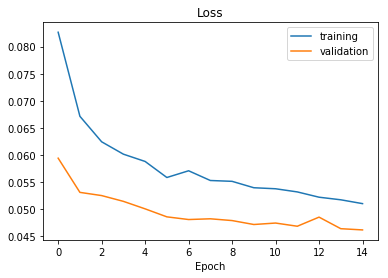

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [32]:
model.save('model.h5') #THis will save the model


Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/repli